In [123]:
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np

class Convert_to_line:
    def __init__(self,im):
        self.im=im
    
    def get_concat_h(self,im1, im2):
        dst = Image.new('RGB', (im1.width + im2.width, im1.height))
        dst.paste(im1, (0, 0))
        dst.paste(im2, (im1.width, 0))
        return dst
    

    #Rightside crop    
    def right_crop(self):
        #Top Crop
        width,height=self.im.size
        top=0.15*height
        bottom=1.015*height/2

        right=0.9*width
        left=1*width/2
        im1=self.im.crop((left,top,right,bottom))


        #Bottom Crop
        top=1.015*height/2
        bottom=0.875*height

        right=0.9*width
        left=1*width/2
        im2=self.im.crop((left,top,right,bottom)).resize(im1.size)

        IM1=get_concat_h(im2, im1)
        return IM1

    def left_crop(self):
        #Leftside crop
        #TopCrop
        width,height=self.im.size
        top=0.15*height
        bottom=1.015*height/2

        left=1*width/9
        right=1*width/2.1
        im1=self.im.crop((left,top,right,bottom))

        #Bottom Crop
        top=1.015*height/2
        bottom=0.875*height

        left=1*width/9
        right=1*width/2.1
        im2=self.im.crop((left,top,right,bottom)).resize(im1.size)

        imlist =[im1,im2]
        IM2=get_concat_h(im2, im1)
        return IM2
    
    def merge(self,IM2, IM1):
        IM=get_concat_h(IM2, IM1)
        return IM

In [13]:
#Step 1: Convert pdf to png
import glob, sys, fitz

# To get better resolution
zoom_x = 2.0  # horizontal zoom
zoom_y = 2.0  # vertical zoom
mat = fitz.Matrix(zoom_x, zoom_y)  # zoom factor 2 in each dimension

all_files = glob.glob(r"C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Raw_Data/1940/All.pdf")

for filename in all_files:
    doc = fitz.open(filename)  # open document
    for page in doc:  # iterate through the pages
        if len(str(page.number))==1:
            pix = page.get_pixmap(matrix=mat)  # render page to an image
            pix.save(r"C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Raw_Data/1940/00%i-page.png" % page.number)  # store image as a PNG
        if len(str(page.number))==2:
            pix = page.get_pixmap(matrix=mat)  # render page to an image
            pix.save(r"C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Raw_Data/1940/0%i-page.png" % page.number)  # store image as a PNG
        else:
            pix = page.get_pixmap(matrix=mat)  # render page to an image
            pix.save(r"C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Raw_Data/1940/%i-page.png" % page.number)  # store image as a PNG

In [129]:
#Convert to line
from PIL import Image
import os, cv2

def listdir_nohidden1(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f
            
for i in range(11,len(sorted(listdir_nohidden1(pathname)))):
    pathname = r'C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Raw_Data/1940'
    image = sorted(listdir_nohidden1(pathname))[i]
    image_test = Image.open(pathname+"/"+image)
    
    test=Convert_to_line(image_test)
    line=test.merge(test.right_crop(),test.left_crop())
    
    line.save(pathname+"/"+image)


UnidentifiedImageError: cannot identify image file 'C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Raw_Data/1940/All.pdf'

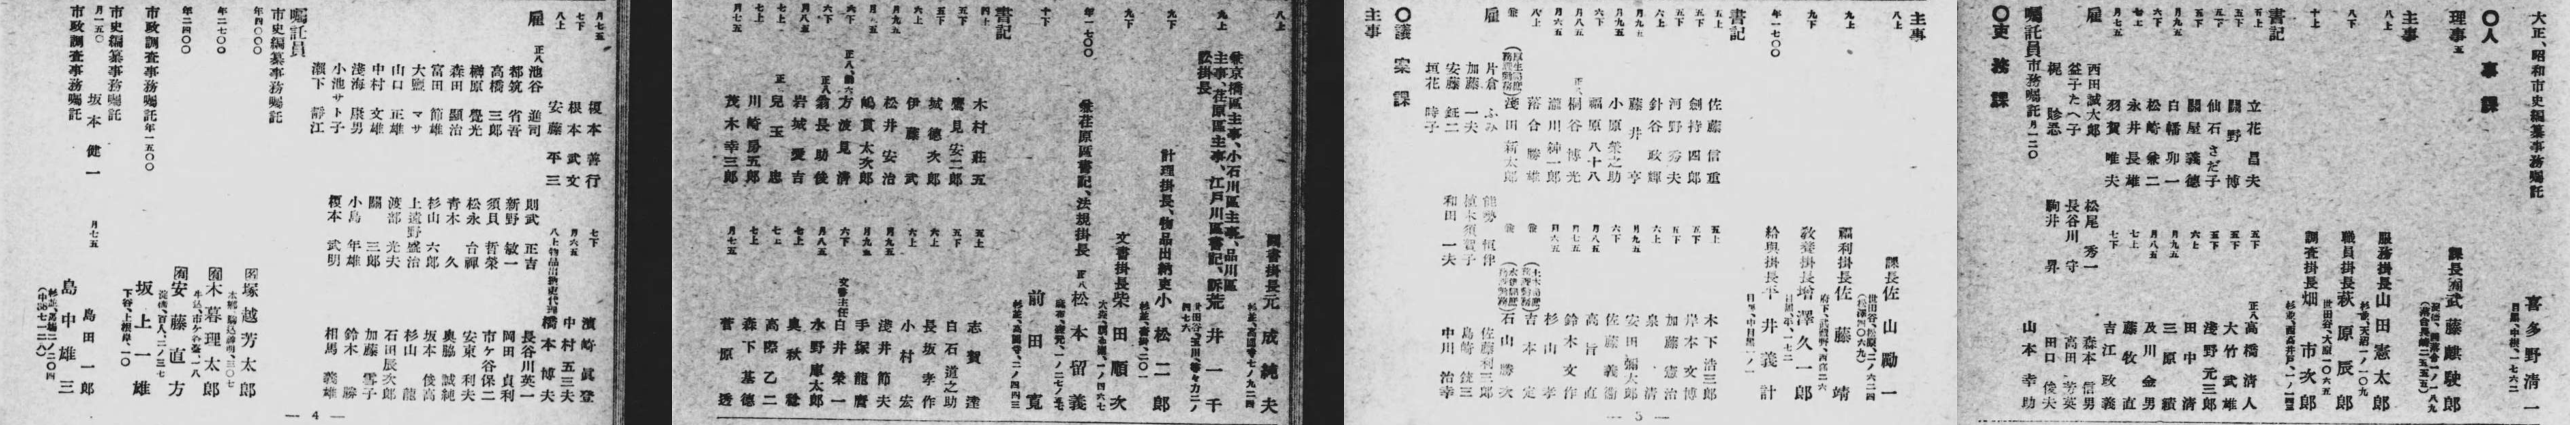

In [122]:
test=Convert_to_line(image_test)
test.merge(test.right_crop(),test.left_crop())

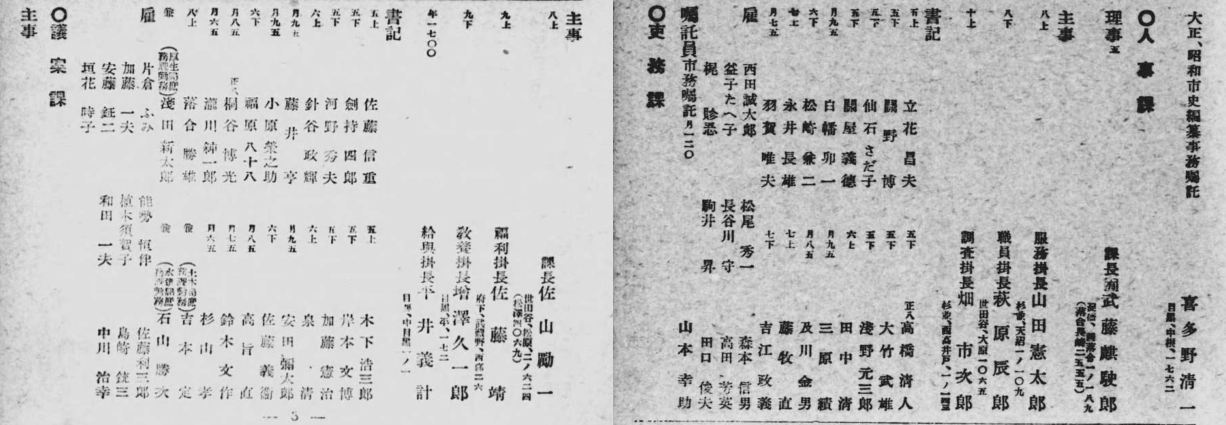

In [115]:
test.right_crop()

In [10]:
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np

src_img = cv2.cvtColor(np.array(Crop(im).CropR()), cv2.COLOR_RGB2BGR)
cv2.imshow('Original Image',src_img)

dst_img = cv2.Canny(src_img, 50, 200, None, 3)

linesP = cv2.HoughLinesP(dst_img, 1, np.pi / 180, 150, None, 0, 0)

[ 83 485  83 479]


In [14]:
for i in range(0, len(linesP)):
            lin = linesP[i][0]
            cv2.line(src_img, (lin[0], lin[1]), (lin[2], lin[3]), (0,0,255), 3, cv2.LINE_AA)

cv2.imshow("Image with lines", src_img)
cv2.waitKey(0)

-1

In [20]:
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np

allfiles = os.listdir()
imlist =[cv2.imread(filename) for filename in allfiles if filename[-4:] in [".jpg"]]
concat_img = np.hstack(imlist)

In [21]:
cv2.imshow('Horizontal Appended', concat_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#Step 2: Detecting departments within an image
import cv2
import matplotlib.pyplot as plt
import numpy as np

im=cv2.imread(r"C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Data_Collection/TestUR.jpg",cv2.IMREAD_COLOR)

# Detecting circles: This step is heavily refering to the following website https://www.geeksforgeeks.org/circle-detection-using-opencv-python/
# Convert to grayscale.
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))  
# Apply Hough transform on the blurred image.
detected_circles = cv2.HoughCircles(gray_blurred, 
                   cv2.HOUGH_GRADIENT, 1, 100, param1 = 50,
               param2 = 15, minRadius = 5, maxRadius = 10)
#The Detection can be eye-checked by projecting an annotated image
#Skip this step for automation.
if detected_circles is not None:
    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))
  
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
  
        # Draw the circumference of the circle.
        cv2.circle(im, (a, b), r, (0, 255, 0), 2)
  
        # Draw a small circle (of radius 1) to show the center.
        cv2.circle(im, (a, b), 1, (0, 0, 255), 3)
        
        cv2.imshow("Detected Circle", im)
        cv2.waitKey(0)

In [7]:
import os
from os import listdir

import cv2
import matplotlib.pyplot as plt
import numpy as np

for images in os.listdir(): 
    if (images.endswith(".jpg")):
        im=cv2.imread(images,cv2.IMREAD_COLOR)
        
        # Detecting circles: This step is heavily refering to the following website https://www.geeksforgeeks.org/circle-detection-using-opencv-python/
        # Convert to grayscale.
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        # Blur using 3 * 3 kernel.
        gray_blurred = cv2.blur(gray, (3, 3))  
        # Apply Hough transform on the blurred image.
        detected_circles = cv2.HoughCircles(gray_blurred, 
                           cv2.HOUGH_GRADIENT, 1, 100, param1 = 50,
                       param2 = 15, minRadius = 5, maxRadius = 10)
        #The Detection can be eye-checked by projecting an annotated image
        #Skip this step for automation.
        if detected_circles is not None:
            # Convert the circle parameters a, b and r to integers.
            detected_circles = np.uint16(np.around(detected_circles))

            for pt in detected_circles[0, :]:
                a, b, r = pt[0], pt[1], pt[2]

                # Draw the circumference of the circle.
                cv2.circle(im, (a, b), r, (0, 255, 0), 2)

                # Draw a small circle (of radius 1) to show the center.
                cv2.circle(im, (a, b), 1, (0, 0, 255), 3)

                cv2.imshow("Detected Circle", im)
                cv2.waitKey(0)

In [22]:
#Step 1: Download image and crop to rows
#The following code crops out the first row.
#Future code will have a function for each row.
from PIL import Image
im = Image.open(r"C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Raw_Data/digidepo_1454729_100-1101024_1.jpg")
im.show()

In [19]:
Crop(im,"Test").Crop_UR()
Crop(im,"Test").Crop_MR()
Crop(im,"Test").Crop_BR()
Crop(im,"Test").Crop_UL()
Crop(im,"Test").Crop_ML()
Crop(im,"Test").Crop_BL()

In [36]:
#Step 2: Detecting departments within an image
import cv2
import matplotlib.pyplot as plt
import numpy as np

im=cv2.imread(r"C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Data_Collection/TestUR.jpg",cv2.IMREAD_COLOR)

#Detecting circles: This step is heavily refering to the following website https://www.geeksforgeeks.org/circle-detection-using-opencv-python/
# Convert to grayscale.
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# Blur using 3 * 3 kernel.
gray_blurred = cv2.blur(gray, (3, 3))  
# Apply Hough transform on the blurred image.
detected_circles = cv2.HoughCircles(gray_blurred, 
                   cv2.HOUGH_GRADIENT, 1, 100, param1 = 50,
               param2 = 15, minRadius = 5, maxRadius = 10)
#The Detection can be eye-checked by projecting an annotated image
#Skip this step for automation.
if detected_circles is not None:
    # Convert the circle parameters a, b and r to integers.
    detected_circles = np.uint16(np.around(detected_circles))
  
    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]
  
        # Draw the circumference of the circle.
        cv2.circle(im, (a, b), r, (0, 255, 0), 2)
  
        # Draw a small circle (of radius 1) to show the center.
        cv2.circle(im, (a, b), 1, (0, 0, 255), 3)
        
        cv2.imshow("Detected Circle", im)
        cv2.waitKey(0)

In [38]:
#Step 3: Cutting image into departments
im = Image.open(r"C:/Users/Keitaro Ninomiya/Box/Research Notes (keitaro2@illinois.edu)/Tokyo_Jobs/Data_Collection/Test.jpg")
height=im.size[1]
left=detected_circles[0][1][0]+20
top=0
right=detected_circles[0][0][0]+20
bottom=height
im1 = im.crop((left,top,right,bottom))
im1 = im1.save("TestUR_dept.jpg")